In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.basemap import Basemap # plot on map projections
import netCDF4 as nc
import IPython.display
import cmocean
from glob import glob
import os,sys
import yaml
import math
import xarray as xr
import copy

sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return
fileprefix = ''

In [3]:
data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict

# inputs used for final runs, copied from /short/public
data['1deg']['mominput'] = 'access-om2/input_236a3011/mom_1deg'
data['025deg']['mominput'] = 'access-om2/input_236a3011/mom_025deg'
data['01deg']['mominput'] = 'access-om2/input_38570c62/mom_01deg'

In [4]:
# add new ryf run
data['01deg_jra55v13_ryf9091'] = \
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf9091/',
               'desc': 'ACCESS-OM2-01 RYF 1990-91',
               'n_files': None,
#                'time_units': 'days since 0001-01-01',
               'time_units': 'days since 1988-01-01', # so .sel(time=slice(pd.datetime(1998,1,1),None)) removes first 10 years
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/',
               'mominput': 'access-om2/input_08022019/mom_01deg'}
fileprefix = 'new_'

In [5]:
for ekey in data.keys():
    e = data[ekey]
    outdirs = glob(os.path.join(e['exptdir'], 'output*'))
    outdirs.sort()
    e['lastout'] = outdirs[-1]
    print(ekey, e['lastout'])
    e['st_edges_ocean'] = xr.open_dataset(e['lastout']+'/ocean/ocean.nc').st_edges_ocean#.values
    e['kmt'] = xr.open_dataset(e['lastout']+'/ocean/ocean_grid.nc').kmt #.values
    e['depth'] = xr.open_dataset(e['mominput']+'/topog.nc').depth  # partial depth
    kmt_idx = e['kmt'].astype(np.int64).clip(min=0)
    tmp = e['st_edges_ocean'][kmt_idx]  # full depth, land is zero
    e['depth_full'] = tmp.where(tmp > 0)  # full depth, land is nan
    dzfull = e['st_edges_ocean'].diff('st_edges_ocean')
    dzftmp = dzfull[e['kmt'].astype(np.int64).clip(min=1)-1]  # full depth dz, land is wrong
    e['dz_full'] = dzftmp.where(tmp > 0)  # full depth dz, land is nan
    dztmp = e['depth'].values - e['st_edges_ocean'][(kmt_idx-1).clip(min=0)]  # partial depth dz, land is wrong
    e['dz'] = dztmp.where(tmp > 0)  # partial depth dz, land is nan

1deg /g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1/output059
025deg /g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output153
01deg /g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output197
01deg_jra55v13_ryf9091 /g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/output160


In [16]:
for ekey in data.keys():
    e = data[ekey]
    print(ekey, e['desc'])
    print('min levels =', int(e['kmt'].min().item(0)))
    print('min partial cell depth   =', e['depth'].where(e['depth']>0).min().item(0),'m')
#     print('min full cell depth =', e['st_edges_ocean'][int(e['kmt'].min().item(0))].item(0),'m')
    print('min full cell depth =', e['depth_full'].min().item(0),'m')
    print('max full cell depth =', e['depth_full'].max().item(0),'m')
    print('min partial cell thickness at bottom =', e['dz'].min().item(0),'m')
    print('min full cell thickness at bottom =', e['dz_full'].min().item(0),'m')
    ratio = e['dz']/e['dz_full']
    print('min partial/full thickness at bottom =', ratio.min().item(0))
    print('max partial/full thickness at bottom =', ratio.max().item(0))
    print('number of cells with partial > full thickness at bottom =', ratio.where(ratio>1).count().item(0))
    print('max partial-full thickness at bottom =', (e['dz']-e['dz_full']).max().item(0))
    print()

1deg ACCESS-OM2
min levels = 10
min partial cell depth   = 45.111485611302065 m
min full cell depth = 51.04873935697576 m
max full cell depth = 5363.469120676253 m
min partial cell thickness at bottom = 2.9616320801266482 m
min full cell thickness at bottom = 9.308074817051192 m
min partial/full thickness at bottom = 0.20000000298023027
max partial/full thickness at bottom = 1.0
number of cells with partial > full thickness at bottom = 0
max partial-full thickness at bottom = 0.0

025deg ACCESS-OM2-025
min levels = 9
min partial cell depth   = 40.355926513671875 m
min full cell depth = 41.740664539924566 m
max full cell depth = 5363.469120676253 m
min partial cell thickness at bottom = 3.4559898943524416 m
min full cell thickness at bottom = 7.971549214042142 m
min partial/full thickness at bottom = 0.20000000298023027
max partial/full thickness at bottom = 1.0
number of cells with partial > full thickness at bottom = 0
max partial-full thickness at bottom = 0.0

01deg ACCESS-OM2-01
mi

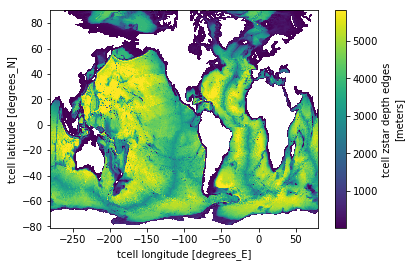

In [7]:
e['depth_full'].plot()

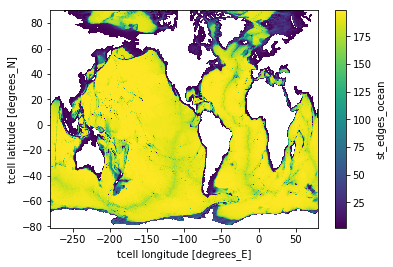

In [8]:
e['dz_full'].plot()

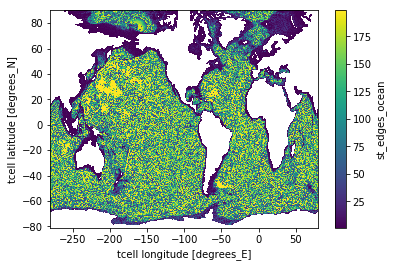

In [9]:
e['dz'].plot()

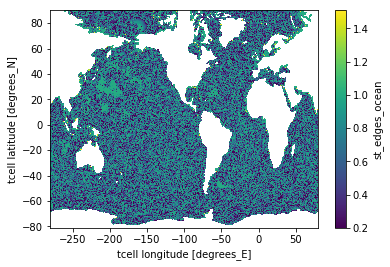

In [10]:
ratio.plot()

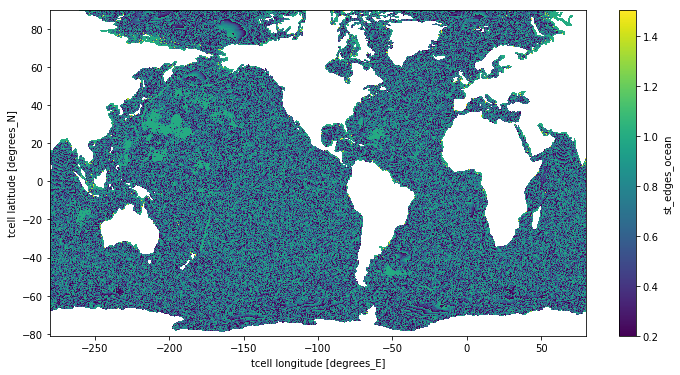

In [23]:
ratio.where(ratio>-1).plot(figsize=(12,6))

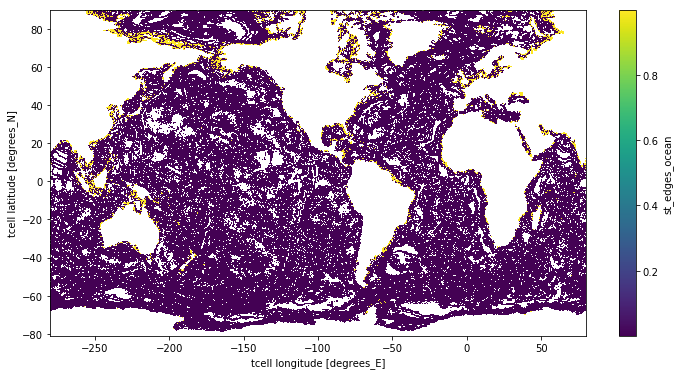

In [22]:
thickdiff = e['dz']-e['dz_full']
thickdiff.where(thickdiff>=0).plot(figsize=(12,6))

In [12]:
# depth below which there is some degree of partial cell
data['01deg']['st_edges_ocean'][1:].where(e['st_edges_ocean'].diff('st_edges_ocean')>10)

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 75)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  103.020921,  114.916569,
        128.057163,  142.571677,  158.601991,  176.304021,  195.848899,
        217.424171,  241.234991,  267.505267,  296.478698,  328.419629,
        363.613608,  402.367523,  445.009148,  491.885883,  543.362463,
        599.817368,  661.637658,  729.211985,  802.921614,  883.129412,
        970.166985, 1064.32043 , 1165.81552 , 1274.803471, 1391.348715,
       1515.420165, 1646.88731 , 1785.521992, 1931.006066, 2082.94433 ,
       2240.881435, 2404.321033, 2572.745269, 2745.632958, 2922.475179,
       3102.787584, 3286.119189, 3472.057852, 3660.232873, 3850.315322,
       

In [13]:
# depth below which 20% threshold is actual lower limit
data['01deg']['st_edges_ocean'][1:].where(e['st_edges_ocean'].diff('st_edges_ocean')>50)

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 75)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,  543.362463,
        599.817368,  661.637658,  729.211985,  802.921614,  883.129412,
        970.166985, 1064.32043 , 1165.81552 , 1274.803471, 1391.348715,
       1515.420165, 1646.88731 , 1785.521992, 1931.006066, 2082.94433 ,
       2240.881435, 2404.321033, 2572.745269, 2745.632958, 2922.475179,
       3102.787584, 3286.119189, 3472.057852, 3660.232873, 3850.315322,
       

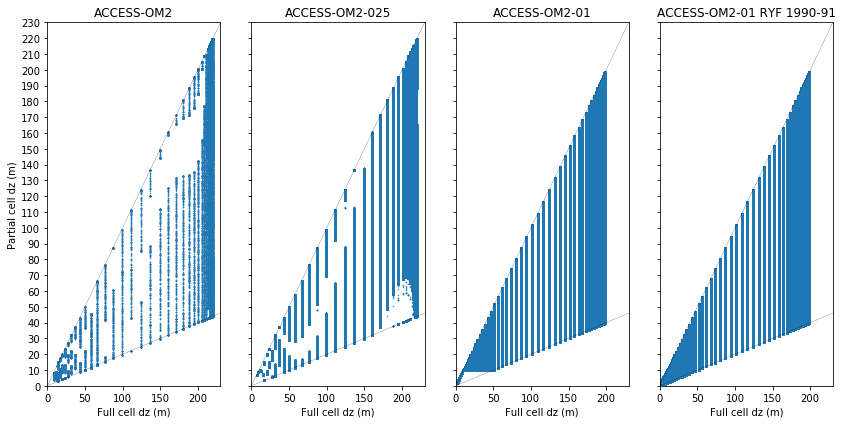

In [14]:
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,len(data.keys()),i+1)
    plt.plot([0, 230],[0,230],'k',linewidth=0.2)
    plt.plot([0, 230],[0,230*0.2],'k',linewidth=0.2)
    plt.scatter(e['dz_full'], e['dz'], s=0.2)
    plt.xlim(0,230)
    plt.ylim(0,230)
    plt.yticks(np.arange(0, 231, step=10))
    plt.xlabel('Full cell dz (m)')
    plt.title(e['desc'])
    if i == 0:
        plt.ylabel('Partial cell dz (m)')
    else:
        plt.gca().axes.yaxis.set_ticklabels([])
plt.tight_layout()
savefigure(fileprefix+'partialcells.png')

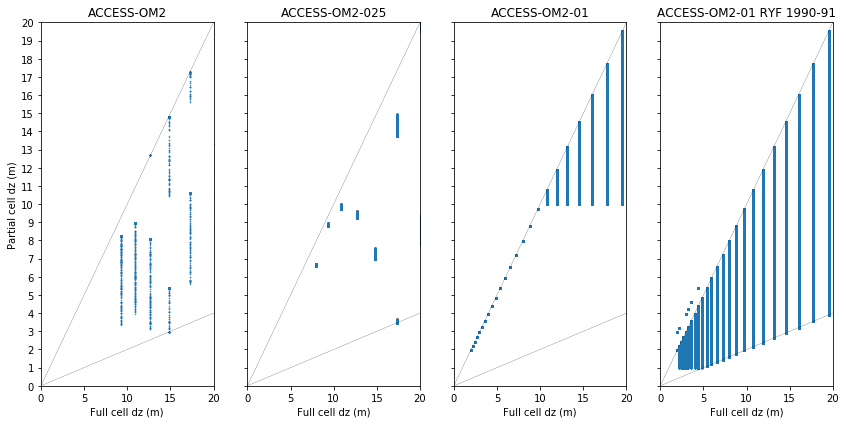

In [15]:
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,len(data.keys()),i+1)
    plt.plot([0, 20],[0,20],'k',linewidth=0.2)
    plt.plot([0, 20],[0,20*0.2],'k',linewidth=0.2)
    plt.scatter(e['dz_full'], e['dz'], s=0.2)
    plt.xlim(0,20)
    plt.ylim(0,20)
    plt.yticks(np.arange(0, 21, step=1))
    plt.xlabel('Full cell dz (m)')
    plt.title(e['desc'])
    if i == 0:
        plt.ylabel('Partial cell dz (m)')
    else:
        plt.gca().axes.yaxis.set_ticklabels([])
plt.tight_layout()
savefigure(fileprefix+'partialcells_closeup.png')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


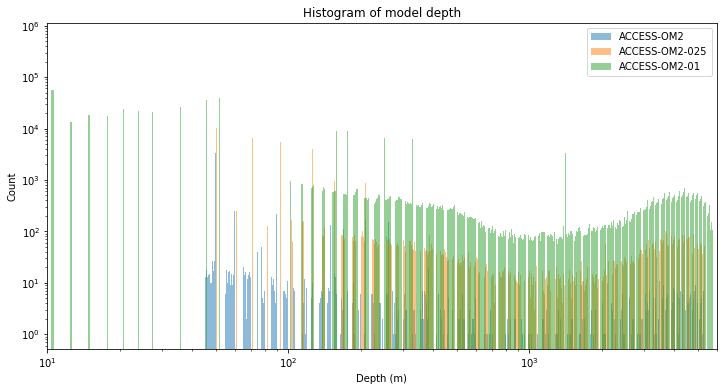

In [9]:
plt.figure(figsize=(12,6))
for ekey in data.keys():
    e = data[ekey]
    plt.hist(np.ma.ravel(e['depth']), bins=20000, alpha=0.5, log=True, label=e['desc'])
plt.xlim(10,6000)
plt.xscale('log')
plt.xlabel('Depth (m)')
plt.ylabel('Count');
plt.title('Histogram of model depth');
plt.legend(loc='upper right')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >

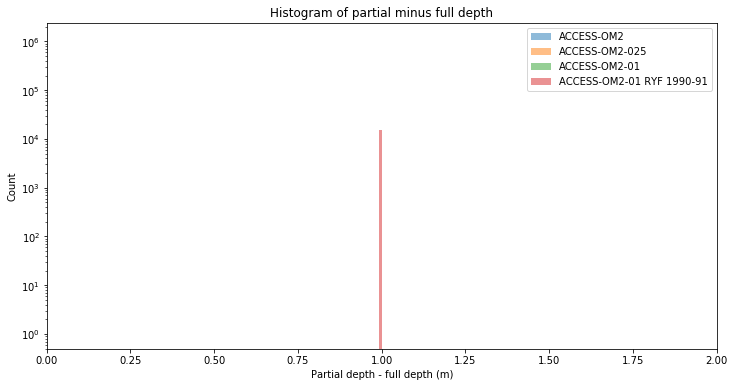

In [20]:
plt.figure(figsize=(12,6))
for ekey in data.keys():
    e = data[ekey]
    plt.hist(np.ma.ravel(e['dz']-e['dz_full']), bins=20000, alpha=0.5, log=True, label=e['desc'])
plt.xlim(0.001,2)
plt.xlabel('Partial depth - full depth (m)')
plt.ylabel('Count');
plt.title('Histogram of partial minus full depth');
plt.legend(loc='upper right')

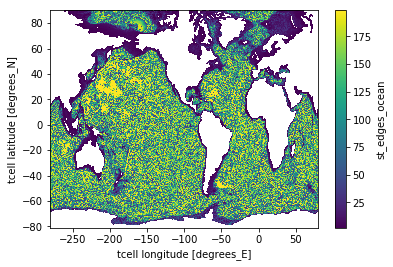

In [10]:
e['dz'].plot()

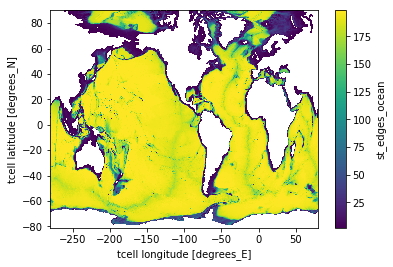

In [11]:
e['dz_full'].plot()

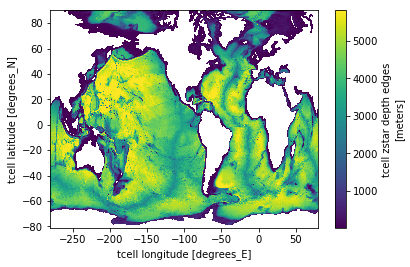

In [12]:
e['depth_full'].plot()

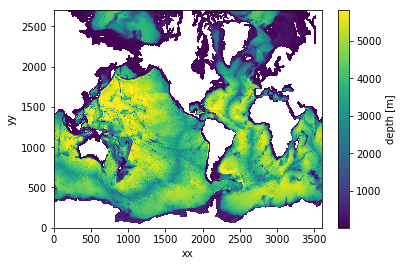

In [13]:
e['depth'].plot()